In [ ]:
import os
# Enable MPS fallback for unsupported operations
# This allows PyTorch to use CPU for specific ops not yet on MPS while keeping most ops on MPS
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_networkx, from_networkx
from transformers import AutoModel, AutoTokenizer
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

# scikit-learn imports
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Use Apple Silicon M3 chip
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
    print("Note: MPS fallback enabled for unsupported operations (will use CPU only for those)")
else:
    device = torch.device("cpu")
    print("Using CPU")

/opt/anaconda3/envs/BatGPT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS (Apple Silicon GPU)
Note: MPS fallback enabled for unsupported operations (will use CPU only for those)


The purpose of this file is to see if we can identify clusters across all of the chirps, as a preliminary measure to ensure that there is enough cross-chirp similarity to create clusters of sequences of chirps. 

In [2]:
# Load data
df = pd.read_feather("src/data/orig_chirps_2024-06-25T12_55_03.feather")
df_Coto = df[df['species'] == 'Coto'].copy()

print(f"Total chirps: {len(df_Coto)}")
print(f"Original columns: {len(df_Coto.columns)}")

# Note: Metadata (file_id, TimeInFile) will remain in df_Coto for later recovery
# We only remove them from the feature matrix used for clustering

# Identify columns to drop
# Metadata columns
metadata_cols = ['species', 'file_id', 'TimeInFile', 'chirp_idx', 'split', 'rec_datetime']
# Processing parameters
processing_cols = ['MinAccpQuality', 'Max#CallsConsidered', 'cntxt_sz']
# Temporal features (to avoid bias)
temporal_cols = ['sin_year', 'cos_year', 'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_hr', 'cos_hr']
# Redundant features
redundant_cols = ['PrecedingIntrvl', 'CallsPerSec']  # PrecedingIntrvl redundant with TimeInFile, CallsPerSec constant per recording
# is_daytime
daytime_cols = ['is_daytime']

amplitude_cols = ['PrcntMaxAmpDur', 'HiFtoFcExpAmp', 'KnToFcExpAmp', 'HiFtoKnExpAmp', 'Amp1stQrtl', 'Amp2ndQrtl', 'Amp3rdQrtl', 'Amp4thQrtl', 'Amp1stMean', 'Amp2ndMean', 'Amp3rdMean', 'Amp4thMean', 'LnExpA_StartAmp', 'LnExpB_StartAmp', 'AmpStartLn60ExpC', 'LnExpA_EndAmp', 'LnExpB_EndAmp', 'AmpEndLn60ExpC', 'AmpK@start', 'AmpK@end', 'AmpKurtosis', 'AmpSkew', 'AmpGausR2', 'HiFtoUpprKnAmp', 'HiFtoKnAmp', 'HiFtoFcAmp', 'UpprKnToKnAmp', 'KnToFcAmp', 'LdgToFcAmp']

all_cols_to_drop = metadata_cols + processing_cols + temporal_cols + redundant_cols + daytime_cols + amplitude_cols

# Keep only columns that exist in the dataframe
cols_to_drop = [col for col in all_cols_to_drop if col in df_Coto.columns]

print(f"\nDropping {len(cols_to_drop)} columns:")
print(f"  - Metadata: {[c for c in metadata_cols if c in df_Coto.columns]}")
print(f"  - Temporal: {[c for c in temporal_cols if c in df_Coto.columns]}")
print(f"  - Processing: {[c for c in processing_cols if c in df_Coto.columns]}")
print(f"  - Other: {[c for c in redundant_cols + daytime_cols if c in df_Coto.columns]}")

# Create feature dataframe (acoustic features only)
df_features = df_Coto.drop(cols_to_drop, axis=1)

print(f"\nFeature dataframe shape: {df_features.shape}")
print(f"Number of acoustic features: {len(df_features.columns)}")
print(f"\nFirst few feature columns: {list(df_features.columns[:10])}")
print(f"\nChecking for any remaining temporal/metadata features...")
# Note: TimeFromMaxToFc and *Residue features are acoustic measurements, not temporal metadata
remaining_suspicious = [col for col in df_features.columns 
                       if any(x in col.lower() for x in 
                       ['file', 'id', 'year', 'month', 'day', 'hour', 'datetime', 'timeinfile', 'precedingintrvl'])]
if remaining_suspicious:
    print(f"  WARNING: Found potentially temporal/metadata columns: {remaining_suspicious}")
else:
    print(f"  ✓ All temporal and metadata columns removed")
    print(f"  Note: TimeFromMaxToFc and *Residue features are acoustic timing within chirps, not temporal metadata")

print(f"\nSample of feature data:")
print(df_features.head())


Total chirps: 116696
Original columns: 122

Dropping 49 columns:
  - Metadata: ['species', 'file_id', 'TimeInFile', 'chirp_idx', 'split', 'rec_datetime']
  - Temporal: ['sin_year', 'cos_year', 'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_hr', 'cos_hr']
  - Processing: ['MinAccpQuality', 'Max#CallsConsidered', 'cntxt_sz']
  - Other: ['PrecedingIntrvl', 'CallsPerSec', 'is_daytime']

Feature dataframe shape: (116696, 73)
Number of acoustic features: 73

First few feature columns: ['CallDuration', 'Fc', 'HiFreq', 'LowFreq', 'Bndwdth', 'FreqMaxPwr', 'TimeFromMaxToFc', 'FreqKnee', 'PrcntKneeDur', 'StartF']

Checking for any remaining temporal/metadata features...

Sample of feature data:
     CallDuration         Fc     HiFreq    LowFreq    Bndwdth  FreqMaxPwr  \
376      1.938217  28.629242  30.228125  28.516158   1.711968   29.705094   
377      6.634022  26.999339  45.047842  26.674439  18.373403   32.216358   
378      6.765964  28.533386  43.510754  28.526536  14.984217   30.207

In [3]:
# List all column labels containing "Amp"
"""
amp_columns = [col for col in df_Coto.columns if 'Amp' in col]

print(f"Found {len(amp_columns)} columns containing 'Amp':")
print("\nColumn list:")
for i, col in enumerate(amp_columns, 1):
    print(f"  {i}. {col}")

print("\n" + "="*70)
print("Amplitude columns list:")
print(amp_columns)
"""

'\namp_columns = [col for col in df_Coto.columns if \'Amp\' in col]\n\nprint(f"Found {len(amp_columns)} columns containing \'Amp\':")\nprint("\nColumn list:")\nfor i, col in enumerate(amp_columns, 1):\n    print(f"  {i}. {col}")\n\nprint("\n" + "="*70)\nprint("Amplitude columns list:")\nprint(amp_columns)\n'

**Goal**: This notebook clusters ALL 116,696 Coto chirps based purely on acoustic features, ignoring temporal and spatial context. 

The purpose is to identify if there are distinct acoustic "types" of chirps across the entire dataset. Unlike the graph-based analysis in `Bat Chirp Analysis.ipynb` which treats recordings as sequences, this analysis treats each chirp independently to discover fundamental acoustic categories.

**Key Points**:
- All chirps included (daytime and nighttime)
- No temporal information used (removed sin_hr, cos_hr, sin_day, etc.)
- No recording context (removed file_id from features)
- Pure acoustic clustering based on 102 features
- Metadata (file_id, TimeInFile) preserved for post-clustering analysis

After clustering, we can analyze:
- Which acoustic types appear across multiple recordings
- Whether certain recordings favor specific chirp types
- If there's enough acoustic diversity to support sequence-based analysis



In [4]:
# Step 1: Normalize features
print("="*70)
print("STEP 1: FEATURE NORMALIZATION")
print("="*70)

# Check for NaN or inf values
nan_count = df_features.isna().sum().sum()
inf_count = np.isinf(df_features.values).sum()

print(f"NaN values: {nan_count}")
print(f"Inf values: {inf_count}")

if nan_count > 0:
    print("Handling NaN values by filling with column median...")
    df_features = df_features.fillna(df_features.median())

if inf_count > 0:
    print("Handling Inf values by replacing with column max/min...")
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    df_features = df_features.fillna(df_features.median())

# Standardize features (mean=0, std=1)
print("\nStandardizing features (StandardScaler)...")
scaler = StandardScaler()
features_normalized = scaler.fit_transform(df_features)

print(f"Normalized feature array shape: {features_normalized.shape}")
print(f"Mean of first feature: {features_normalized[:, 0].mean():.6f} (should be ~0)")
print(f"Std of first feature: {features_normalized[:, 0].std():.6f} (should be ~1)")
print("\n✓ Feature normalization complete!")

# Apply PCA for dimensionality reduction (speeds up clustering dramatically)
print("\n" + "="*70)
print("STEP 1.5: DIMENSIONALITY REDUCTION (PCA)")
print("="*70)
print("\nReducing from 102 to 30 dimensions...")
print("Benefits: Faster clustering, removes noise, addresses curse of dimensionality")

pca = PCA(n_components=30, random_state=42)
features_reduced = pca.fit_transform(features_normalized)

variance_explained = pca.explained_variance_ratio_.sum()
print(f"\n✓ PCA complete!")
print(f"  Reduced shape: {features_reduced.shape}")
print(f"  Variance retained: {variance_explained:.2%}")
print(f"  Top 4 components explain: {pca.explained_variance_ratio_[:4].sum():.2%}")

# Show variance per component
print(f"\nVariance explained by each of first 10 components:")
for i, var in enumerate(pca.explained_variance_ratio_[:10], 1):
    print(f"  PC{i}: {var:.2%}")

# Show what PC1, PC2, PC3 represent (top contributing features)
print(f"\n" + "="*70)
print("TOP FEATURES IN PRINCIPAL COMPONENTS")
print("="*70)

feature_names = df_features.columns.tolist()

for pc_idx in range(3):  # PC1, PC2, PC3
    print(f"\n--- PC{pc_idx+1} (explains {pca.explained_variance_ratio_[pc_idx]:.2%} of variance) ---")
    
    # Get loadings (how much each original feature contributes to this PC)
    loadings = pca.components_[pc_idx]
    
    # Get absolute values for ranking (magnitude matters, not direction)
    abs_loadings = np.abs(loadings)
    
    # Get indices of top 10 features
    top_indices = np.argsort(abs_loadings)[-10:][::-1]
    
    print("Top 10 contributing features:")
    for rank, idx in enumerate(top_indices, 1):
        # Show actual loading (with sign) and feature name
        loading = loadings[idx]
        sign = "+" if loading > 0 else "-"
        print(f"  {rank}. {feature_names[idx]}: {sign}{abs_loadings[idx]:.4f}")

print(f"\n✓ Ready for clustering with {features_reduced.shape[1]} dimensions!")



STEP 1: FEATURE NORMALIZATION
NaN values: 0
Inf values: 0

Standardizing features (StandardScaler)...


Normalized feature array shape: (116696, 73)
Mean of first feature: 0.000000 (should be ~0)
Std of first feature: 1.000000 (should be ~1)

✓ Feature normalization complete!

STEP 1.5: DIMENSIONALITY REDUCTION (PCA)

Reducing from 102 to 30 dimensions...
Benefits: Faster clustering, removes noise, addresses curse of dimensionality

✓ PCA complete!
  Reduced shape: (116696, 30)
  Variance retained: 94.67%
  Top 4 components explain: 54.40%

Variance explained by each of first 10 components:
  PC1: 26.35%
  PC2: 12.83%
  PC3: 8.81%
  PC4: 6.41%
  PC5: 4.57%
  PC6: 4.13%
  PC7: 3.83%
  PC8: 2.89%
  PC9: 2.24%
  PC10: 2.13%

TOP FEATURES IN PRINCIPAL COMPONENTS

--- PC1 (explains 26.35% of variance) ---
Top 10 contributing features:
  1. FFwd15dB: +0.1989
  2. FFwd20dB: +0.1956
  3. HiFreq: +0.1935
  4. StartF: +0.1927
  5. FFwd5dB: +0.1893
  6. FreqCtr: +0.1882
  7. TotalSlope: +0.1815
  8. CummNmlzdSlp: +0.1805
  9. freq_mean: +0.1697
  10. UpprKnFreq: +0.1682

--- PC2 (explains 12.83% of

In [5]:
# Step 2: Apply HDBSCAN clustering
print("\n" + "="*70)
print("STEP 2: HDBSCAN CLUSTERING")
print("="*70)

# Sample data for faster clustering
sample_size = 50000

sample_indices = np.random.choice(len(features_reduced), sample_size, replace=False)

sample_features = features_reduced[sample_indices]

print(f"\nSampling {sample_size:,} chirps for faster clustering...")
print(f"Sample represents {sample_size/len(features_reduced)*100:.1f}% of total data")
print(f"Sample shape: {sample_features.shape}")
print(f"(To use all {len(features_reduced):,} chirps, comment out the sampling lines)")

print("\nHDBSCAN Parameters:")
print("  - min_cluster_size: 5 (minimum chirps to form a cluster)")
print("  - min_samples: 5 (neighborhood size for core point density)")
print("  - metric: euclidean")
print("  - cluster_selection_method: eom (excess of mass)")
print(f"\nClustering {sample_size:,} sampled chirps in 30-dimensional PCA space...")
print("Expected time: 5-15 seconds")

import time
start_time = time.time()

# Apply HDBSCAN (on sampled PCA-reduced features for speed)
clusterer = HDBSCAN(
    min_cluster_size=10,   # Restored to 100 for meaningful clusters
    min_samples=5,         # Restored to 50 for better performance
    metric='euclidean',
    cluster_selection_method='eom',
    algorithm='kd_tree',       # Let HDBSCAN choose optimal algorithm
    n_jobs=-1               # Use all CPU cores
)

sample_cluster_labels = clusterer.fit_predict(sample_features)  # Cluster on sample!

elapsed = time.time() - start_time
print(f"\n✓ Clustering complete in {elapsed:.1f} seconds!")

# Analyze sample results
unique_clusters = set(sample_cluster_labels)
num_clusters = len(unique_clusters - {-1})  # Exclude noise (-1)
num_noise = sum(sample_cluster_labels == -1)
num_clustered = len(sample_cluster_labels) - num_noise

print("\n" + "="*70)
print("CLUSTERING RESULTS (on sample)")
print("="*70)
print(f"Sampled chirps: {len(sample_cluster_labels):,}")
print(f"Number of clusters found: {num_clusters}")
print(f"Clustered chirps: {num_clustered:,} ({num_clustered/len(sample_cluster_labels)*100:.2f}%)")
print(f"Noise points: {num_noise:,} ({num_noise/len(sample_cluster_labels)*100:.2f}%)")

# Cluster size distribution (in sample)
cluster_sizes = Counter(sample_cluster_labels)
if -1 in cluster_sizes:
    del cluster_sizes[-1]  # Remove noise from size stats

cluster_sizes_sorted = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)

print(f"\nCluster size statistics (in sample):")
sizes_only = [size for _, size in cluster_sizes_sorted]
print(f"  Mean cluster size: {np.mean(sizes_only):.1f} chirps")
print(f"  Median cluster size: {np.median(sizes_only):.1f} chirps")
print(f"  Largest cluster: {max(sizes_only):,} chirps")
print(f"  Smallest cluster: {min(sizes_only):,} chirps")

print(f"\nTop 10 largest clusters (in sample):")
for i, (cluster_id, size) in enumerate(cluster_sizes_sorted[:10], 1):
    print(f"  {i}. Cluster {cluster_id}: {size:,} chirps ({size/len(sample_cluster_labels)*100:.2f}%)")

# Map sample clusters to full dataset using nearest neighbor
print("\n" + "="*70)
print("MAPPING CLUSTERS TO FULL DATASET")
print("="*70)
print(f"\nAssigning cluster labels to all {len(features_reduced):,} chirps...")
print("Method: Nearest neighbor in PCA space")

# For each point in full dataset, find nearest neighbor in sample and assign its cluster
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=1, algorithm='auto', n_jobs=-1)
knn.fit(sample_features)

# Find nearest sample point for each full dataset point
distances, indices = knn.kneighbors(features_reduced)

# Assign cluster labels based on nearest sample point
cluster_labels = sample_cluster_labels[indices.flatten()]

print(f"✓ Cluster assignment complete!")
print(f"  Total chirps labeled: {len(cluster_labels):,}")
print(f"  Clusters in full dataset: {len(set(cluster_labels) - {-1})}")
print(f"  Noise points in full dataset: {sum(cluster_labels == -1):,} ({sum(cluster_labels == -1)/len(cluster_labels)*100:.2f}%)")




STEP 2: HDBSCAN CLUSTERING

Sampling 50,000 chirps for faster clustering...
Sample represents 42.8% of total data
Sample shape: (50000, 30)
(To use all 116,696 chirps, comment out the sampling lines)

HDBSCAN Parameters:
  - min_cluster_size: 5 (minimum chirps to form a cluster)
  - min_samples: 5 (neighborhood size for core point density)
  - metric: euclidean
  - cluster_selection_method: eom (excess of mass)

Clustering 50,000 sampled chirps in 30-dimensional PCA space...
Expected time: 5-15 seconds

✓ Clustering complete in 45.8 seconds!

CLUSTERING RESULTS (on sample)
Sampled chirps: 50,000
Number of clusters found: 6
Clustered chirps: 49,129 (98.26%)
Noise points: 871 (1.74%)

Cluster size statistics (in sample):
  Mean cluster size: 8188.2 chirps
  Median cluster size: 62.5 chirps
  Largest cluster: 48,782 chirps
  Smallest cluster: 10 chirps

Top 10 largest clusters (in sample):
  1. Cluster 3: 48,782 chirps (97.56%)
  2. Cluster 4: 178 chirps (0.36%)
  3. Cluster 0: 74 chirps

In [6]:
# Step 3: Add cluster_id back to original dataframe
print("\n" + "="*70)
print("STEP 3: ADDING CLUSTER IDs TO DATAFRAME")
print("="*70)

# Add cluster_id to the original df_Coto dataframe
# This preserves the original index and allows recovery of file_id and TimeInFile
df_Coto['cluster_id'] = cluster_labels

print(f"\n✓ Added 'cluster_id' column to df_Coto")
print(f"Dataframe shape: {df_Coto.shape}")
print(f"\nSample of data with cluster_id:")
print(df_Coto[['file_id', 'TimeInFile', 'CallDuration', 'Fc', 'cluster_id']].head(10))

# Verify we can recover metadata for each cluster
print("\n" + "="*70)
print("VERIFICATION: Cluster-to-Metadata Mapping")
print("="*70)

# Show example: for cluster 0, what files does it appear in?
if num_clusters > 0:
    example_cluster = cluster_sizes_sorted[0][0]  # Largest cluster
    cluster_mask = df_Coto['cluster_id'] == example_cluster
    cluster_df = df_Coto[cluster_mask]
    
    print(f"\nExample - Cluster {example_cluster} (largest cluster with {len(cluster_df):,} chirps):")
    print(f"  Appears in {cluster_df['file_id'].nunique()} different recordings")
    print(f"  File IDs: {sorted(cluster_df['file_id'].unique())[:10]}... (showing first 10)")
    print(f"  TimeInFile range: {cluster_df['TimeInFile'].min():.2f} - {cluster_df['TimeInFile'].max():.2f} ms")
    print(f"\n  Sample chirps from this cluster:")
    print(cluster_df[['file_id', 'TimeInFile', 'CallDuration', 'Fc', 'HiFreq', 'LowFreq']].head(5))

print("\n✓ Successfully preserved metadata - can recover file_id and TimeInFile for any cluster!")




STEP 3: ADDING CLUSTER IDs TO DATAFRAME

✓ Added 'cluster_id' column to df_Coto
Dataframe shape: (116696, 123)

Sample of data with cluster_id:
     file_id  TimeInFile  CallDuration         Fc  cluster_id
376       39       172.0      1.938217  28.629242           3
377       39       808.0      6.634022  26.999339           3
378       39      1058.0      6.765964  28.533386           3
379       39      1211.0      3.116399  29.421645           3
380       39      1418.0      6.277149  28.735783           3
381       39      2696.0      6.931797  30.377934           3
382       39      3333.0      6.058051  28.676567           3
383       39      3404.0      5.330664  29.868037           3
384       39      3494.0      5.786975  29.485285           3
385       39      3656.0      6.367162  27.494131           3

VERIFICATION: Cluster-to-Metadata Mapping

Example - Cluster 3 (largest cluster with 114,298 chirps):
  Appears in 5350 different recordings
  File IDs: [np.int64(39), np.i


STEP 4: VISUALIZATION


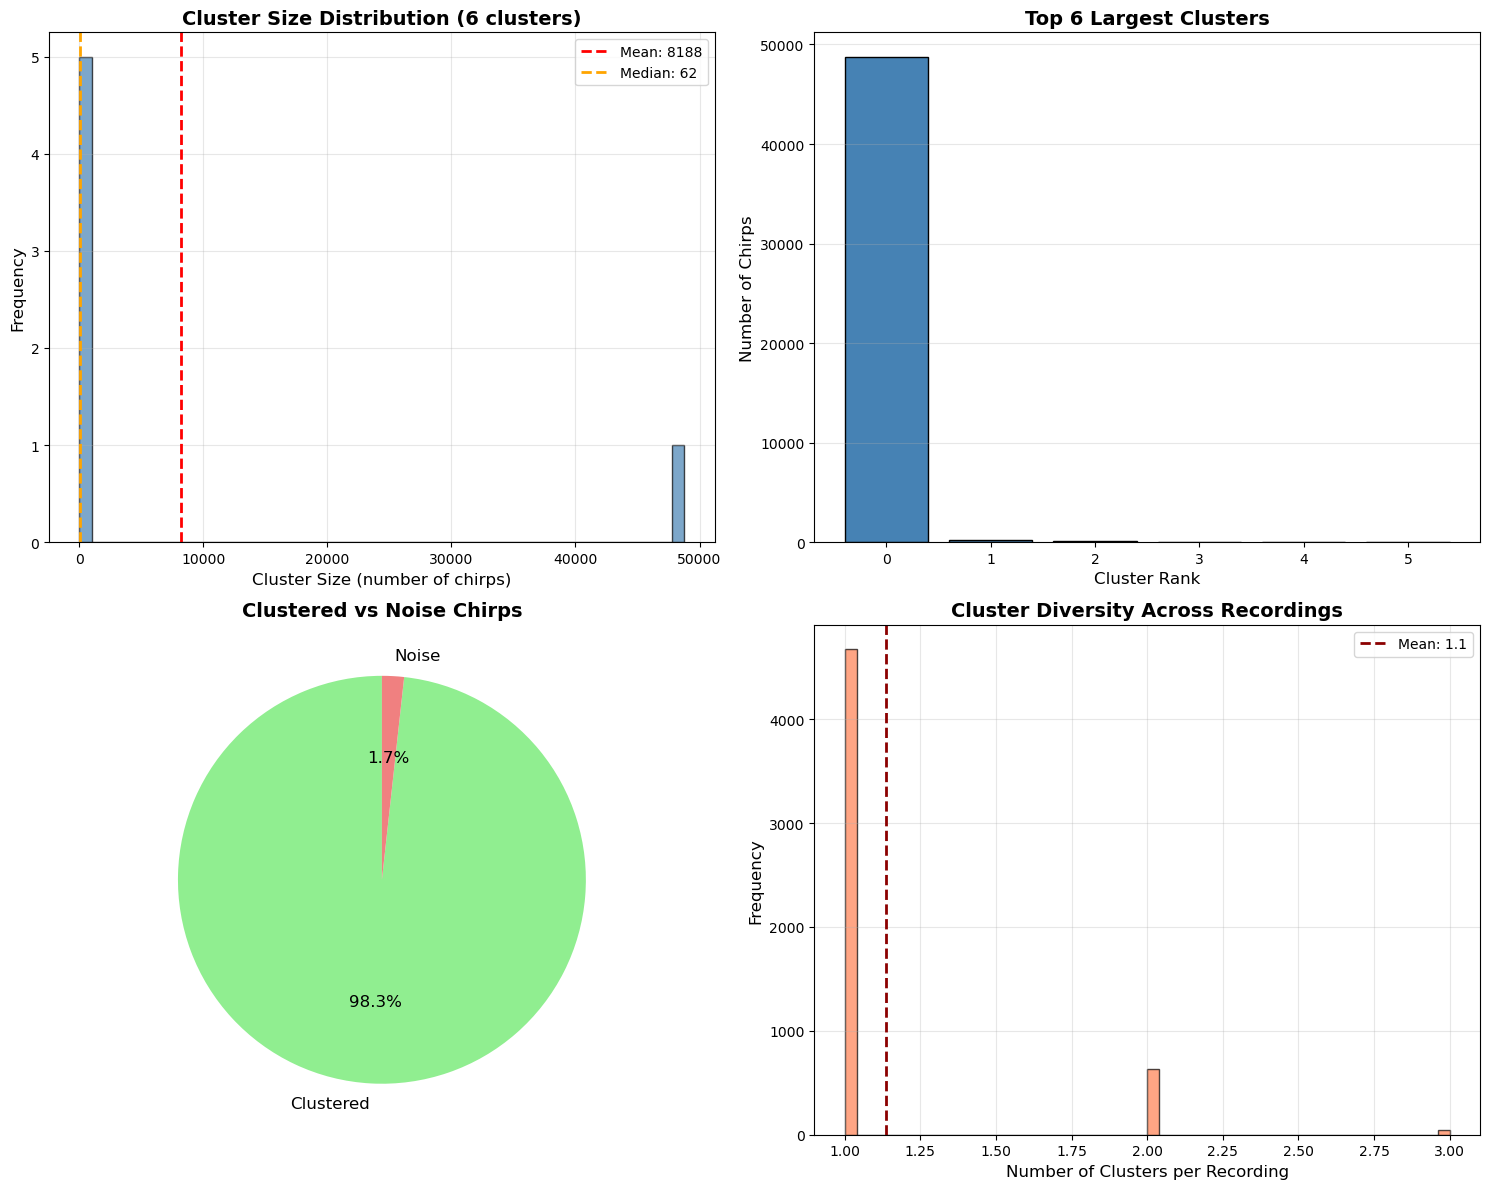


✓ Visualization complete!


In [7]:
# Step 4: Visualize clustering results
print("\n" + "="*70)
print("STEP 4: VISUALIZATION")
print("="*70)

# Plot 1: Cluster size distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histogram of cluster sizes
axes[0, 0].hist(sizes_only, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Cluster Size (number of chirps)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title(f'Cluster Size Distribution ({num_clusters} clusters)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(np.mean(sizes_only), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sizes_only):.0f}')
axes[0, 0].axvline(np.median(sizes_only), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(sizes_only):.0f}')
axes[0, 0].legend()

# Bar plot of top 20 clusters
top_n = min(20, len(cluster_sizes_sorted))
top_clusters = cluster_sizes_sorted[:top_n]
axes[0, 1].bar(range(top_n), [size for _, size in top_clusters], color='steelblue', edgecolor='black')
axes[0, 1].set_xlabel('Cluster Rank', fontsize=12)
axes[0, 1].set_ylabel('Number of Chirps', fontsize=12)
axes[0, 1].set_title(f'Top {top_n} Largest Clusters', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Pie chart of clustered vs noise
labels = ['Clustered', 'Noise']
sizes_pie = [num_clustered, num_noise]
colors = ['lightgreen', 'lightcoral']
axes[1, 0].pie(sizes_pie, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12})
axes[1, 0].set_title('Clustered vs Noise Chirps', fontsize=14, fontweight='bold')

# Distribution of clusters across recordings
cluster_per_file = df_Coto[df_Coto['cluster_id'] != -1].groupby('file_id')['cluster_id'].nunique()
axes[1, 1].hist(cluster_per_file, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].set_xlabel('Number of Clusters per Recording', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Cluster Diversity Across Recordings', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(cluster_per_file.mean(), color='darkred', linestyle='--', linewidth=2, 
                   label=f'Mean: {cluster_per_file.mean():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")



In [8]:
# Step 5: Analyze cluster characteristics
print("\n" + "="*70)
print("STEP 5: CLUSTER CHARACTERISTICS ANALYSIS")
print("="*70)

# For each cluster, compute mean acoustic features
print("\nComputing mean acoustic features for each cluster...")

# Get feature columns (exclude metadata)
feature_cols = df_features.columns.tolist()

# Compute cluster centroids in original feature space
cluster_profiles = df_Coto[df_Coto['cluster_id'] != -1].groupby('cluster_id')[feature_cols].mean()

print(f"\nCluster profiles shape: {cluster_profiles.shape}")
print(f"Features tracked: {len(feature_cols)}")

# Show some interesting features for top clusters
interesting_features = ['CallDuration', 'Fc', 'HiFreq', 'LowFreq', 'Bndwdth', 'FreqMaxPwr']
print(f"\nKey acoustic features for top 5 clusters:")
print(cluster_profiles.loc[[c for c, _ in cluster_sizes_sorted[:5]], interesting_features])

# Analyze temporal distribution of clusters
print("\n" + "="*70)
print("TEMPORAL DISTRIBUTION OF CLUSTERS")
print("="*70)

# For each cluster, see if it appears more in certain times/files
cluster_file_counts = df_Coto[df_Coto['cluster_id'] != -1].groupby('cluster_id')['file_id'].nunique()

print(f"\nCluster prevalence across recordings:")
print(f"  Mean files per cluster: {cluster_file_counts.mean():.1f}")
print(f"  Median files per cluster: {cluster_file_counts.median():.1f}")
print(f"  Max files for a cluster: {cluster_file_counts.max()}")
print(f"  Min files for a cluster: {cluster_file_counts.min()}")

# Find most widespread clusters
most_widespread = cluster_file_counts.sort_values(ascending=False).head(10)
print(f"\nMost widespread clusters (appear in most recordings):")
for cluster_id, num_files in most_widespread.items():
    cluster_size = cluster_sizes[cluster_id]
    print(f"  Cluster {cluster_id}: appears in {num_files} files ({num_files/df_Coto['file_id'].nunique()*100:.1f}% of all recordings), "
          f"total {cluster_size:,} chirps")

# Find most concentrated clusters (appear in few files but have many chirps)
cluster_concentration = {}
for cluster_id in cluster_sizes.keys():
    size = cluster_sizes[cluster_id]
    num_files = cluster_file_counts[cluster_id]
    cluster_concentration[cluster_id] = size / num_files  # chirps per file

most_concentrated = sorted(cluster_concentration.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\nMost concentrated clusters (many chirps in few recordings):")
for cluster_id, conc in most_concentrated:
    size = cluster_sizes[cluster_id]
    num_files = cluster_file_counts[cluster_id]
    print(f"  Cluster {cluster_id}: {conc:.1f} chirps/file (total {size:,} chirps in {num_files} files)")

print("\n✓ Cluster analysis complete!")




STEP 5: CLUSTER CHARACTERISTICS ANALYSIS

Computing mean acoustic features for each cluster...

Cluster profiles shape: (6, 73)
Features tracked: 73

Key acoustic features for top 5 clusters:
            CallDuration         Fc     HiFreq    LowFreq    Bndwdth  \
cluster_id                                                             
3               4.240374  28.033421  46.492532  25.563065  20.929467   
4               3.116809  27.125044  46.253951  23.122379  23.131572   
0               2.743938  57.842912  86.933802  50.431345  36.502457   
2               2.439405  41.712161  41.959598  40.421001   1.538597   
1               3.423619  53.492034  91.432048  50.801027  40.631021   

            FreqMaxPwr  
cluster_id              
3            33.254522  
4            37.028069  
0            62.602635  
2            41.728876  
1            55.653432  

TEMPORAL DISTRIBUTION OF CLUSTERS

Cluster prevalence across recordings:
  Mean files per cluster: 1012.0
  Median files per c


MOST DISCRIMINATIVE FEATURES ACROSS CLUSTERS

Top 20 features that vary most between clusters:
(Higher variance = more discriminative)
  1. PrcntKneeDur: 2946.9424
  2. UpprKnFreq: 778.1380
  3. FreqKnee: 659.1380
  4. StartF: 608.6124
  5. HiFreq: 599.6006
  6. FFwd32dB: 529.1131
  7. FreqLedge: 486.2698
  8. FFwd20dB: 342.4571
  9. FFwd15dB: 288.0834
  10. Bndwdth: 255.3745
  11. FFwd5dB: 253.2210
  12. FreqCtr: 242.8458
  13. FBak5dB: 228.9413
  14. FBak15dB: 213.2365
  15. FBak20dB: 209.4310
  16. Bndw32dB: 204.8411
  17. FBak32dB: 193.7455
  18. Fc: 174.4795
  19. FreqMaxPwr: 152.6440
  20. EndF: 150.5317


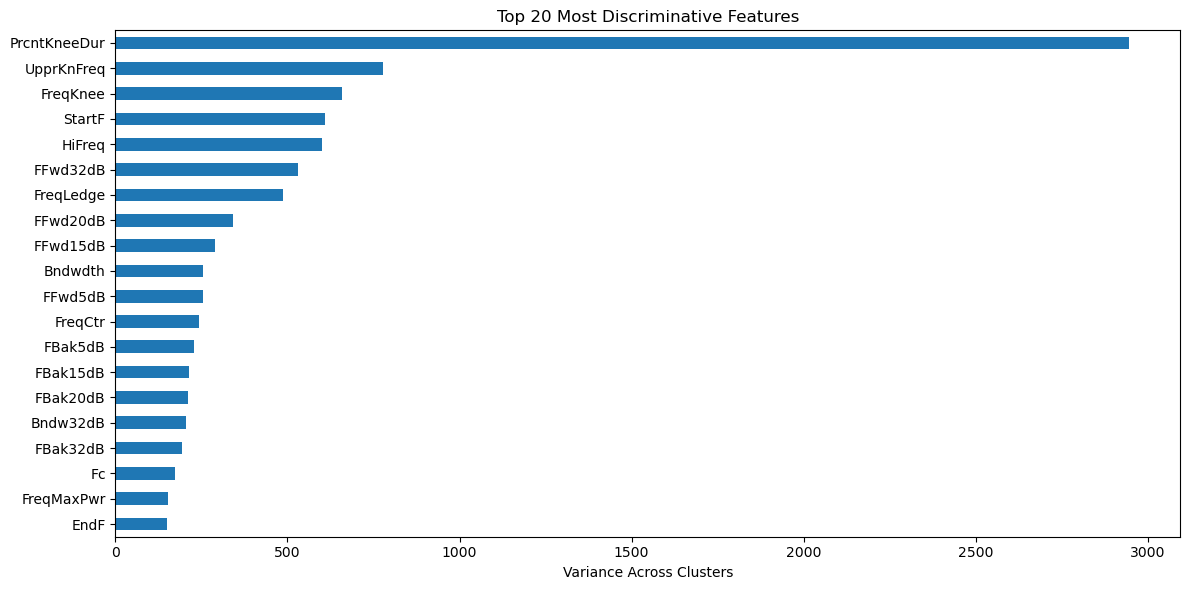

In [9]:
# Add this in Cell 8 (cluster characteristics analysis)

# Compute variance of each feature across cluster centroids
print("\n" + "="*70)
print("MOST DISCRIMINATIVE FEATURES ACROSS CLUSTERS")
print("="*70)

# Get cluster centroids in original feature space
cluster_profiles = df_Coto[df_Coto['cluster_id'] != -1].groupby('cluster_id')[feature_cols].mean()

# Calculate variance across clusters for each feature
feature_variance = cluster_profiles.var(axis=0).sort_values(ascending=False)

print("\nTop 20 features that vary most between clusters:")
print("(Higher variance = more discriminative)")
for i, (feature, variance) in enumerate(feature_variance.head(20).items(), 1):
    print(f"  {i}. {feature}: {variance:.4f}")

# Visualize
plt.figure(figsize=(12, 6))
feature_variance.head(20).plot(kind='barh')
plt.xlabel('Variance Across Clusters')
plt.title('Top 20 Most Discriminative Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---

# Part 2: Graph Attention Network for Sequence Clustering

**Goal**: Identify recurring communication patterns by clustering sequences of chirps using a Graph Attention Network (GAT).

**Approach**:
- Create sequences of k=4 chirps (non-overlapping windows)
- Each sequence becomes a graph: chirps are nodes, consecutive chirps are connected by edges
- Node features: PCA-reduced acoustic features (30 dimensions)
- Edge features: Time intervals between chirps
- GAT learns sequence-level embeddings based on acoustic similarity
- Cluster sequences to find repeated patterns


In [10]:
# Step 1: Create sequences of chirps (k=4, non-overlapping)
print("="*70)
print("STEP 1: CREATING CHIRP SEQUENCES")
print("="*70)

k = 4  # Sequence length (can generalize later)

sequences = []
sequence_metadata = []  # Store file_id and chirp indices for each sequence

# Group by file_id and create sequences
for file_id, file_group in df_Coto.groupby('file_id'):
    file_indices = file_group.index.tolist()
    
    # Create non-overlapping sequences of k chirps
    for i in range(0, len(file_indices) - k + 1, k):  # Step by k for non-overlapping
        seq_indices = file_indices[i:i+k]
        
        if len(seq_indices) == k:  # Ensure full sequence
            sequences.append(seq_indices)
            sequence_metadata.append({
                'file_id': file_id,
                'start_idx': seq_indices[0],
                'end_idx': seq_indices[-1],
                'chirp_indices': seq_indices
            })

print(f"\nCreated {len(sequences):,} sequences")
print(f"Sequence length: {k} chirps")
print(f"Total chirps used: {len(sequences) * k:,} / {len(df_Coto):,} ({len(sequences)*k/len(df_Coto)*100:.1f}%)")

# Show distribution across files
seqs_per_file = pd.Series([meta['file_id'] for meta in sequence_metadata]).value_counts()
print(f"\nSequences per file:")
print(f"  Mean: {seqs_per_file.mean():.1f}")
print(f"  Median: {seqs_per_file.median():.1f}")
print(f"  Max: {seqs_per_file.max()}")
print(f"  Min: {seqs_per_file.min()}")

print("\n✓ Sequence creation complete!")


STEP 1: CREATING CHIRP SEQUENCES

Created 27,329 sequences
Sequence length: 4 chirps
Total chirps used: 109,316 / 116,696 (93.7%)

Sequences per file:
  Mean: 5.1
  Median: 5.0
  Max: 13
  Min: 1

✓ Sequence creation complete!


In [11]:
# Step 2: Create graph representations for each sequence
print("\n" + "="*70)
print("STEP 2: BUILDING SEQUENCE GRAPHS")
print("="*70)

sequence_graphs = []

for seq_idx, chirp_indices in enumerate(sequences):
    # Get PCA features for these chirps (already computed in features_reduced)
    # Need to map from df_Coto indices to features_reduced indices
    features_idx = [df_Coto.index.get_loc(idx) for idx in chirp_indices]
    node_features = features_reduced[features_idx]  # Shape: (k, 30)
    
    # Get time intervals between consecutive chirps
    times = df_Coto.loc[chirp_indices, 'TimeInFile'].values
    time_intervals = np.diff(times)  # Shape: (k-1,)
    
    # Create edges: sequential connections (0→1, 1→2, 2→3)
    edge_index = torch.tensor([[i, i+1] for i in range(k-1)], dtype=torch.long).t()
    
    # Edge features: time intervals (normalized)
    edge_attr = torch.tensor(time_intervals, dtype=torch.float32).unsqueeze(1)  # Shape: (k-1, 1)
    
    # Node features
    x = torch.tensor(node_features, dtype=torch.float32)  # Shape: (k, 30)
    
    # Create PyG Data object
    graph = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        seq_idx=seq_idx  # Track which sequence this is
    )
    
    sequence_graphs.append(graph)

print(f"\nCreated {len(sequence_graphs):,} graph objects")
print(f"\nExample graph structure:")
print(f"  Nodes: {sequence_graphs[0].x.shape[0]} (each with {sequence_graphs[0].x.shape[1]} features)")
print(f"  Edges: {sequence_graphs[0].edge_index.shape[1]}")
print(f"  Edge features: {sequence_graphs[0].edge_attr.shape}")

print("\n✓ Graph construction complete!")



STEP 2: BUILDING SEQUENCE GRAPHS

Created 27,329 graph objects

Example graph structure:
  Nodes: 4 (each with 30 features)
  Edges: 3
  Edge features: torch.Size([3, 1])

✓ Graph construction complete!


In [ ]:
# Step 3: Define Graph Attention Network model
print("\n" + "="*70)
print("STEP 3: DEFINING GAT MODEL")
print("="*70)

from torch_geometric.nn import GATv2Conv, global_mean_pool, global_add_pool

class SequenceGAT(nn.Module):
    """
    Graph Attention Network for learning sequence embeddings.
    
    Architecture:
    - 2 GAT layers with multi-head attention
    - Global pooling to aggregate node features into sequence embedding
    - Optional projection head for contrastive learning
    """
    def __init__(self, 
                 node_dim=30,          # Input node feature dimension
                 edge_dim=1,           # Edge feature dimension
                 hidden_dim=64,        # Hidden dimension
                 embedding_dim=32,     # Output embedding dimension
                 num_heads=4,          # Number of attention heads
                 dropout=0.2):
        super(SequenceGAT, self).__init__()
        
        self.node_dim = node_dim
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        
        # First GAT layer
        self.conv1 = GATv2Conv(
            node_dim, 
            hidden_dim, 
            heads=num_heads,
            dropout=dropout,
            edge_dim=edge_dim,  # Use edge features
            concat=True  # Concatenate attention heads
        )
        
        # Second GAT layer
        self.conv2 = GATv2Conv(
            hidden_dim * num_heads,  # Input is concatenated heads
            embedding_dim,
            heads=1,  # Single head for final layer
            dropout=dropout,
            edge_dim=edge_dim,
            concat=False
        )
        
        self.dropout = dropout
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long)
        
        # First GAT layer
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GAT layer
        x = self.conv2(x, edge_index, edge_attr)
        x = F.elu(x)
        
        # Global pooling: aggregate all nodes in the graph to get sequence embedding
        # Using mean pooling (average of all node embeddings)
        sequence_embedding = global_mean_pool(x, batch)
        
        return sequence_embedding

# Initialize model
model = SequenceGAT(
    node_dim=30,
    edge_dim=1,
    hidden_dim=64,
    embedding_dim=32,
    num_heads=4,
    dropout=0.2
).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print("\n✓ Model defined!")



STEP 3: DEFINING GAT MODEL

Model architecture:
SequenceGAT(
  (conv1): GATv2Conv(30, 64, heads=4)
  (conv2): GATv2Conv(256, 32, heads=1)
)

Model parameters: 33,184
Trainable parameters: 33,184

✓ Model defined!


: 

In [ ]:
# Step 4: Unsupervised training with contrastive learning
print("\n" + "="*70)
print("STEP 4: TRAINING GAT WITH CONTRASTIVE LEARNING")
print("="*70)

print("\nTraining strategy:")
print("  - Contrastive learning: similar sequences should have similar embeddings")
print("  - Positive pairs: sequences from the same recording (acoustically related)")
print("  - Negative pairs: sequences from different recordings")
print("  - Loss: InfoNCE (NT-Xent) contrastive loss")

# Create DataLoader
batch_size = 256
loader = DataLoader(sequence_graphs, batch_size=batch_size, shuffle=True)

print(f"\nDataLoader created:")
print(f"  Batch size: {batch_size}")
print(f"  Number of batches: {len(loader)}")

# Contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, embeddings, labels):
        """
        embeddings: [batch_size, embedding_dim]
        labels: [batch_size] - file_id for each sequence
        """
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Compute similarity matrix
        similarity = torch.matmul(embeddings, embeddings.t()) / self.temperature
        
        # Create positive mask (same file_id)
        labels = labels.unsqueeze(0)
        positive_mask = (labels == labels.t()).float()
        positive_mask.fill_diagonal_(0)  # Remove self-similarity
        
        # Create negative mask
        negative_mask = 1 - positive_mask
        negative_mask.fill_diagonal_(0)
        
        # Compute loss
        # For each anchor, pull positives closer and push negatives away
        exp_sim = torch.exp(similarity)
        
        # Sum of positive similarities
        pos_sum = (exp_sim * positive_mask).sum(dim=1)
        
        # Sum of all non-self similarities (positives + negatives)
        all_sum = (exp_sim * (1 - torch.eye(similarity.size(0), device=similarity.device))).sum(dim=1)
        
        # Loss: -log(pos_sum / all_sum)
        # Only compute for samples that have positives
        has_positive = positive_mask.sum(dim=1) > 0
        if has_positive.sum() > 0:
            loss = -torch.log(pos_sum[has_positive] / (all_sum[has_positive] + 1e-8))
            return loss.mean()
        else:
            return torch.tensor(0.0, device=similarity.device)

# Training setup
criterion = ContrastiveLoss(temperature=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

num_epochs = 50
print(f"\nTraining for {num_epochs} epochs...")

# Training loop
model.train()
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    
    for batch in loader:
        batch = batch.to(device)
        
        # Get file_ids for this batch
        batch_file_ids = torch.tensor([
            sequence_metadata[batch.seq_idx[i].item()]['file_id'] 
            for i in range(len(batch.seq_idx))
        ], device=device)
        
        # Forward pass
        embeddings = model(batch)
        
        # Compute loss
        loss = criterion(embeddings, batch_file_ids)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Contrastive Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



STEP 4: TRAINING GAT WITH CONTRASTIVE LEARNING

Training strategy:
  - Contrastive learning: similar sequences should have similar embeddings
  - Positive pairs: sequences from the same recording (acoustically related)
  - Negative pairs: sequences from different recordings
  - Loss: InfoNCE (NT-Xent) contrastive loss

DataLoader created:
  Batch size: 256
  Number of batches: 107

Training for 50 epochs...


/opt/anaconda3/envs/BatGPT/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


/opt/anaconda3/envs/BatGPT/lib/python3.12/site-packages/torch_geometric/utils/_scatter.py:102: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1742433267209/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


In [ ]:
# Step 5: Extract embeddings for all sequences
print("\n" + "="*70)
print("STEP 5: EXTRACTING SEQUENCE EMBEDDINGS")
print("="*70)

model.eval()
all_embeddings = []

with torch.no_grad():
    for batch in DataLoader(sequence_graphs, batch_size=batch_size, shuffle=False):
        batch = batch.to(device)
        embeddings = model(batch)
        all_embeddings.append(embeddings.cpu().numpy())

# Concatenate all embeddings
all_embeddings = np.vstack(all_embeddings)

print(f"\nExtracted embeddings for {len(all_embeddings):,} sequences")
print(f"Embedding dimension: {all_embeddings.shape[1]}")
print(f"Embedding statistics:")
print(f"  Mean: {all_embeddings.mean():.4f}")
print(f"  Std: {all_embeddings.std():.4f}")
print(f"  Min: {all_embeddings.min():.4f}")
print(f"  Max: {all_embeddings.max():.4f}")

print("\n✓ Embedding extraction complete!")


In [ ]:
# Step 6: Cluster sequence embeddings
print("\n" + "="*70)
print("STEP 6: CLUSTERING SEQUENCE EMBEDDINGS")
print("="*70)

# Apply HDBSCAN to cluster sequences
print("\nApplying HDBSCAN clustering...")
print("Parameters:")
print("  - min_cluster_size: 50")
print("  - min_samples: 10")
print("  - metric: euclidean")

seq_clusterer = HDBSCAN(
    min_cluster_size=50,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom',
    n_jobs=-1
)

sequence_cluster_labels = seq_clusterer.fit_predict(all_embeddings)

# Analyze clustering results
unique_seq_clusters = set(sequence_cluster_labels)
num_seq_clusters = len(unique_seq_clusters - {-1})
num_seq_noise = sum(sequence_cluster_labels == -1)
num_seq_clustered = len(sequence_cluster_labels) - num_seq_noise

print(f"\n" + "="*70)
print("SEQUENCE CLUSTERING RESULTS")
print("="*70)
print(f"Total sequences: {len(sequence_cluster_labels):,}")
print(f"Number of sequence clusters: {num_seq_clusters}")
print(f"Clustered sequences: {num_seq_clustered:,} ({num_seq_clustered/len(sequence_cluster_labels)*100:.2f}%)")
print(f"Noise sequences: {num_seq_noise:,} ({num_seq_noise/len(sequence_cluster_labels)*100:.2f}%)")

# Cluster size distribution
seq_cluster_sizes = Counter(sequence_cluster_labels)
if -1 in seq_cluster_sizes:
    del seq_cluster_sizes[-1]

seq_cluster_sizes_sorted = sorted(seq_cluster_sizes.items(), key=lambda x: x[1], reverse=True)

print(f"\nSequence cluster statistics:")
sizes_only_seq = [size for _, size in seq_cluster_sizes_sorted]
print(f"  Mean cluster size: {np.mean(sizes_only_seq):.1f} sequences")
print(f"  Median cluster size: {np.median(sizes_only_seq):.1f} sequences")
print(f"  Largest cluster: {max(sizes_only_seq):,} sequences")
print(f"  Smallest cluster: {min(sizes_only_seq):,} sequences")

print(f"\nTop 10 largest sequence clusters:")
for i, (cluster_id, size) in enumerate(seq_cluster_sizes_sorted[:10], 1):
    print(f"  {i}. Cluster {cluster_id}: {size:,} sequences ({size/len(sequence_cluster_labels)*100:.2f}%)")

print("\n✓ Sequence clustering complete!")


In [ ]:
# Step 7: Visualize sequence clusters with t-SNE
print("\n" + "="*70)
print("STEP 7: VISUALIZING SEQUENCE CLUSTERS")
print("="*70)

print("\nApplying t-SNE for 2D visualization...")
print("This may take a few minutes for large datasets...")

# Apply t-SNE (sample if dataset is too large)
max_samples_tsne = 10000
if len(all_embeddings) > max_samples_tsne:
    print(f"Sampling {max_samples_tsne:,} sequences for t-SNE (out of {len(all_embeddings):,})")
    sample_idx = np.random.choice(len(all_embeddings), max_samples_tsne, replace=False)
    embeddings_tsne = all_embeddings[sample_idx]
    labels_tsne = sequence_cluster_labels[sample_idx]
else:
    embeddings_tsne = all_embeddings
    labels_tsne = sequence_cluster_labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_tsne)

print("✓ t-SNE complete!")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Plot 1: t-SNE colored by cluster
ax1 = axes[0, 0]
scatter = ax1.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=labels_tsne,
    cmap='tab20',
    alpha=0.6,
    s=20,
    edgecolors='none'
)
ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax1.set_title('Sequence Clusters in t-SNE Space', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Cluster ID')
ax1.grid(True, alpha=0.3)

# Plot 2: Cluster size distribution
ax2 = axes[0, 1]
ax2.hist(sizes_only_seq, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.set_xlabel('Cluster Size (number of sequences)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Sequence Cluster Size Distribution ({num_seq_clusters} clusters)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(np.mean(sizes_only_seq), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sizes_only_seq):.0f}')
ax2.axvline(np.median(sizes_only_seq), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(sizes_only_seq):.0f}')
ax2.legend()

# Plot 3: Top 15 clusters
ax3 = axes[1, 0]
top_n_seq = min(15, len(seq_cluster_sizes_sorted))
top_clusters_seq = seq_cluster_sizes_sorted[:top_n_seq]
ax3.bar(range(top_n_seq), [size for _, size in top_clusters_seq], color='coral', edgecolor='black')
ax3.set_xlabel('Cluster Rank', fontsize=12)
ax3.set_ylabel('Number of Sequences', fontsize=12)
ax3.set_title(f'Top {top_n_seq} Largest Sequence Clusters', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Clustered vs Noise pie chart
ax4 = axes[1, 1]
labels_pie = ['Clustered', 'Noise']
sizes_pie_seq = [num_seq_clustered, num_seq_noise]
colors_pie = ['lightgreen', 'lightcoral']
ax4.pie(sizes_pie_seq, labels=labels_pie, autopct='%1.1f%%', startangle=90, colors=colors_pie, textprops={'fontsize': 12})
ax4.set_title('Clustered vs Noise Sequences', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")


In [ ]:
# Step 8: Compute similarity scores and analyze patterns
print("\n" + "="*70)
print("STEP 8: COMPUTING SEQUENCE SIMILARITIES")
print("="*70)

# Normalize embeddings for cosine similarity
embeddings_normalized = all_embeddings / np.linalg.norm(all_embeddings, axis=1, keepdims=True)

print("\nComputing pairwise cosine similarities...")
print("(Using a sample for efficiency)")

# Sample sequences for similarity computation (full matrix would be huge)
n_sample_sim = 1000
sample_indices_sim = np.random.choice(len(all_embeddings), min(n_sample_sim, len(all_embeddings)), replace=False)
sample_embeddings = embeddings_normalized[sample_indices_sim]

# Compute similarity matrix
similarity_matrix = cosine_similarity(sample_embeddings)

print(f"\nSimilarity matrix shape: {similarity_matrix.shape}")
print(f"Similarity statistics (excluding self-similarity):")

# Get upper triangle (excluding diagonal)
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
print(f"  Mean similarity: {upper_triangle.mean():.4f}")
print(f"  Median similarity: {np.median(upper_triangle):.4f}")
print(f"  Std similarity: {upper_triangle.std():.4f}")
print(f"  Min similarity: {upper_triangle.min():.4f}")
print(f"  Max similarity: {upper_triangle.max():.4f}")

# Find most similar sequence pairs
print("\n" + "="*70)
print("MOST SIMILAR SEQUENCE PAIRS")
print("="*70)

# Get indices of top 10 most similar pairs
top_k = 10
flat_indices = np.argpartition(upper_triangle, -top_k)[-top_k:]
flat_indices = flat_indices[np.argsort(-upper_triangle[flat_indices])]

# Convert flat indices back to 2D indices
triu_indices = np.triu_indices_from(similarity_matrix, k=1)
top_pairs_i = triu_indices[0][flat_indices]
top_pairs_j = triu_indices[1][flat_indices]

print(f"\nTop {top_k} most similar sequence pairs:")
for rank, (i, j, flat_idx) in enumerate(zip(top_pairs_i, top_pairs_j, flat_indices), 1):
    idx_i = sample_indices_sim[i]
    idx_j = sample_indices_sim[j]
    similarity = upper_triangle[flat_idx]
    
    # Get metadata
    meta_i = sequence_metadata[idx_i]
    meta_j = sequence_metadata[idx_j]
    
    same_file = meta_i['file_id'] == meta_j['file_id']
    file_marker = "✓ SAME FILE" if same_file else "✗ Different files"
    
    print(f"\n  {rank}. Similarity: {similarity:.4f} {file_marker}")
    print(f"     Seq {idx_i}: File {meta_i['file_id']}, indices {meta_i['start_idx']}-{meta_i['end_idx']}")
    print(f"     Seq {idx_j}: File {meta_j['file_id']}, indices {meta_j['start_idx']}-{meta_j['end_idx']}")

# Visualize similarity matrix
print("\n" + "="*70)
print("SIMILARITY MATRIX VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Heatmap of similarity matrix (sample)
sample_size_viz = min(200, len(similarity_matrix))
ax1 = axes[0]
im1 = ax1.imshow(similarity_matrix[:sample_size_viz, :sample_size_viz], cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax1.set_xlabel('Sequence Index', fontsize=12)
ax1.set_ylabel('Sequence Index', fontsize=12)
ax1.set_title(f'Pairwise Sequence Similarity (first {sample_size_viz} sequences)', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Cosine Similarity')

# Plot 2: Distribution of similarities
ax2 = axes[1]
ax2.hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax2.set_xlabel('Cosine Similarity', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Pairwise Similarities', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(upper_triangle.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {upper_triangle.mean():.3f}')
ax2.axvline(np.median(upper_triangle), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(upper_triangle):.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n✓ Similarity analysis complete!")


In [ ]:
# Step 9: Analyze sequence cluster characteristics
print("\n" + "="*70)
print("STEP 9: ANALYZING SEQUENCE CLUSTER PATTERNS")
print("="*70)

# Create a dataframe with sequence information
sequence_df = pd.DataFrame({
    'seq_idx': range(len(sequences)),
    'cluster_id': sequence_cluster_labels,
    'file_id': [meta['file_id'] for meta in sequence_metadata],
    'start_idx': [meta['start_idx'] for meta in sequence_metadata],
    'end_idx': [meta['end_idx'] for meta in sequence_metadata]
})

print(f"\nSequence dataframe shape: {sequence_df.shape}")
print(f"\nSample sequences:")
print(sequence_df.head(10))

# Analyze cross-file recurrence
print("\n" + "="*70)
print("CROSS-FILE PATTERN ANALYSIS")
print("="*70)

# For each cluster, count how many different files it appears in
cluster_file_distribution = sequence_df[sequence_df['cluster_id'] != -1].groupby('cluster_id')['file_id'].agg(['nunique', 'count'])
cluster_file_distribution.columns = ['num_files', 'num_sequences']
cluster_file_distribution['avg_per_file'] = cluster_file_distribution['num_sequences'] / cluster_file_distribution['num_files']
cluster_file_distribution = cluster_file_distribution.sort_values('num_files', ascending=False)

print("\nTop 15 most widespread clusters (appear in most recordings):")
for i, (cluster_id, row) in enumerate(cluster_file_distribution.head(15).iterrows(), 1):
    print(f"  {i}. Cluster {cluster_id}:")
    print(f"     - Appears in {row['num_files']} files ({row['num_files']/df_Coto['file_id'].nunique()*100:.1f}% of all recordings)")
    print(f"     - Total sequences: {int(row['num_sequences'])}")
    print(f"     - Avg per file: {row['avg_per_file']:.1f}")

# Identify "signature" patterns (appear frequently across many files)
print("\n" + "="*70)
print("SIGNATURE COMMUNICATION PATTERNS")
print("="*70)
print("\nCriteria: Clusters that appear in >10% of files with >5 sequences per file on average")

signature_clusters = cluster_file_distribution[
    (cluster_file_distribution['num_files'] > df_Coto['file_id'].nunique() * 0.1) &
    (cluster_file_distribution['avg_per_file'] > 5)
]

print(f"\nFound {len(signature_clusters)} signature patterns:")
for i, (cluster_id, row) in enumerate(signature_clusters.iterrows(), 1):
    print(f"\n  Signature Pattern #{i} (Cluster {cluster_id}):")
    print(f"    - Files: {row['num_files']} ({row['num_files']/df_Coto['file_id'].nunique()*100:.1f}%)")
    print(f"    - Total sequences: {int(row['num_sequences'])}")
    print(f"    - Avg per file: {row['avg_per_file']:.1f}")
    
    # Get example sequences from this cluster
    cluster_seqs = sequence_df[sequence_df['cluster_id'] == cluster_id].head(3)
    print(f"    - Example sequences:")
    for _, seq_row in cluster_seqs.iterrows():
        print(f"      • File {seq_row['file_id']}, indices {seq_row['start_idx']}-{seq_row['end_idx']}")

# Visualize cluster distribution across files
print("\n" + "="*70)
print("VISUALIZATION: CLUSTER DISTRIBUTION")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Number of files per cluster
ax1 = axes[0]
ax1.hist(cluster_file_distribution['num_files'], bins=50, edgecolor='black', alpha=0.7, color='teal')
ax1.set_xlabel('Number of Files Cluster Appears In', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Cross-File Distribution of Sequence Clusters', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(cluster_file_distribution['num_files'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {cluster_file_distribution["num_files"].mean():.1f}')
ax1.legend()

# Plot 2: Average sequences per file
ax2 = axes[1]
ax2.scatter(cluster_file_distribution['num_files'], cluster_file_distribution['avg_per_file'], 
           alpha=0.6, s=cluster_file_distribution['num_sequences']*0.5, c='purple', edgecolors='black')
ax2.set_xlabel('Number of Files', fontsize=12)
ax2.set_ylabel('Average Sequences per File', fontsize=12)
ax2.set_title('Cluster Spread vs Concentration', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

print("\n✓ Pattern analysis complete!")


In [ ]:
# Step 10: Summary and export
print("\n" + "="*70)
print("SUMMARY: SEQUENCE CLUSTERING WITH GAT")
print("="*70)

print(f"""
SEQUENCE CREATION:
==================
✓ Created {len(sequences):,} sequences of k={k} chirps (non-overlapping)
✓ Sequences respect file boundaries (no cross-file sequences)
✓ Coverage: {len(sequences)*k/len(df_Coto)*100:.1f}% of chirps used

GRAPH ATTENTION NETWORK:
========================
✓ Architecture: 2-layer GAT with multi-head attention
✓ Node features: PCA-reduced acoustic features (30 dimensions)
✓ Edge features: Time intervals between chirps
✓ Training: Unsupervised contrastive learning ({num_epochs} epochs)
✓ Embedding dimension: {all_embeddings.shape[1]}

CLUSTERING RESULTS:
===================
✓ Number of sequence clusters: {num_seq_clusters}
✓ Clustered sequences: {num_seq_clustered:,} ({num_seq_clustered/len(sequence_cluster_labels)*100:.2f}%)
✓ Noise sequences: {num_seq_noise:,} ({num_seq_noise/len(sequence_cluster_labels)*100:.2f}%)
✓ Mean cluster size: {np.mean(sizes_only_seq):.1f} sequences
✓ Median cluster size: {np.median(sizes_only_seq):.1f} sequences

PATTERN DISCOVERY:
==================
✓ Identified {len(signature_clusters)} signature communication patterns
✓ Patterns recur across multiple recordings
✓ Mean similarity between sequences: {upper_triangle.mean():.4f}

DATA AVAILABLE:
===============
• sequence_df: DataFrame with sequence metadata and cluster labels
• all_embeddings: Sequence embeddings (shape: {all_embeddings.shape})
• sequence_cluster_labels: Cluster ID for each sequence
• similarity_matrix: Pairwise similarities (sample)
• model: Trained GAT model

USAGE EXAMPLES:
===============
# Get all sequences from cluster 0
cluster_0_sequences = sequence_df[sequence_df['cluster_id'] == 0]

# Get sequences from a specific file
file_39_sequences = sequence_df[sequence_df['file_id'] == 39]

# Compute similarity between two sequences
seq1_emb = embeddings_normalized[0]
seq2_emb = embeddings_normalized[1]
similarity = np.dot(seq1_emb, seq2_emb)

# Get the chirps that make up a sequence
seq_chirps = df_Coto.loc[sequences[0]]  # First sequence
""")

print("\n" + "="*70)
print("OPTIONAL: Save results")
print("="*70)
print("\nUncomment to save:")
print("# sequence_df.to_csv('sequence_clusters.csv', index=False)")
print("# np.save('sequence_embeddings.npy', all_embeddings)")
print("# torch.save(model.state_dict(), 'gat_model.pt')")

print("\n" + "="*70)
print("✓ SEQUENCE CLUSTERING COMPLETE!")
print("="*70)


---

## Generalizing to Different Sequence Lengths (k)

The code above is designed for k=4 chirps, but can be easily adapted for any k. Below is a helper function to rerun the entire pipeline with a different sequence length.


In [ ]:
def cluster_sequences_with_gat(k=4, 
                               hidden_dim=64, 
                               embedding_dim=32, 
                               num_heads=4,
                               num_epochs=50,
                               batch_size=256,
                               min_cluster_size=50,
                               min_samples=10,
                               verbose=True):
    """
    Complete pipeline to cluster chirp sequences using GAT.
    
    Parameters:
    -----------
    k : int
        Length of sequences (number of chirps)
    hidden_dim : int
        Hidden dimension in GAT
    embedding_dim : int
        Output embedding dimension
    num_heads : int
        Number of attention heads in first GAT layer
    num_epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
    min_cluster_size : int
        HDBSCAN min_cluster_size parameter
    min_samples : int
        HDBSCAN min_samples parameter
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    results : dict
        Dictionary containing:
        - sequences: list of chirp index sequences
        - sequence_metadata: list of metadata dicts
        - sequence_graphs: list of PyG Data objects
        - model: trained GAT model
        - embeddings: sequence embeddings array
        - cluster_labels: cluster labels for each sequence
        - sequence_df: DataFrame with sequence info
    """
    import time
    start_time = time.time()
    
    if verbose:
        print("="*70)
        print(f"CLUSTERING SEQUENCES WITH k={k}")
        print("="*70)
    
    # Step 1: Create sequences
    if verbose:
        print(f"\n[1/6] Creating sequences...")
    sequences = []
    sequence_metadata = []
    
    for file_id, file_group in df_Coto.groupby('file_id'):
        file_indices = file_group.index.tolist()
        
        for i in range(0, len(file_indices) - k + 1, k):
            seq_indices = file_indices[i:i+k]
            
            if len(seq_indices) == k:
                sequences.append(seq_indices)
                sequence_metadata.append({
                    'file_id': file_id,
                    'start_idx': seq_indices[0],
                    'end_idx': seq_indices[-1],
                    'chirp_indices': seq_indices
                })
    
    if verbose:
        print(f"  Created {len(sequences):,} sequences")
    
    # Step 2: Build graphs
    if verbose:
        print(f"[2/6] Building sequence graphs...")
    sequence_graphs = []
    
    for seq_idx, chirp_indices in enumerate(sequences):
        features_idx = [df_Coto.index.get_loc(idx) for idx in chirp_indices]
        node_features = features_reduced[features_idx]
        
        times = df_Coto.loc[chirp_indices, 'TimeInFile'].values
        time_intervals = np.diff(times)
        
        edge_index = torch.tensor([[i, i+1] for i in range(k-1)], dtype=torch.long).t()
        edge_attr = torch.tensor(time_intervals, dtype=torch.float32).unsqueeze(1)
        x = torch.tensor(node_features, dtype=torch.float32)
        
        graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, seq_idx=seq_idx)
        sequence_graphs.append(graph)
    
    if verbose:
        print(f"  Built {len(sequence_graphs):,} graphs")
    
    # Step 3: Define and train model
    if verbose:
        print(f"[3/6] Training GAT model...")
    
    model = SequenceGAT(
        node_dim=30,
        edge_dim=1,
        hidden_dim=hidden_dim,
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        dropout=0.2
    ).to(device)
    
    loader = DataLoader(sequence_graphs, batch_size=batch_size, shuffle=True)
    criterion = ContrastiveLoss(temperature=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0
        
        for batch in loader:
            batch = batch.to(device)
            batch_file_ids = torch.tensor([
                sequence_metadata[batch.seq_idx[i].item()]['file_id'] 
                for i in range(len(batch.seq_idx))
            ], device=device)
            
            embeddings = model(batch)
            loss = criterion(embeddings, batch_file_ids)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/num_batches:.4f}")
    
    # Step 4: Extract embeddings
    if verbose:
        print(f"[4/6] Extracting embeddings...")
    
    model.eval()
    all_embeddings = []
    
    with torch.no_grad():
        for batch in DataLoader(sequence_graphs, batch_size=batch_size, shuffle=False):
            batch = batch.to(device)
            embeddings = model(batch)
            all_embeddings.append(embeddings.cpu().numpy())
    
    all_embeddings = np.vstack(all_embeddings)
    
    if verbose:
        print(f"  Extracted {len(all_embeddings):,} embeddings")
    
    # Step 5: Cluster
    if verbose:
        print(f"[5/6] Clustering sequences...")
    
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        cluster_selection_method='eom',
        n_jobs=-1
    )
    
    cluster_labels = clusterer.fit_predict(all_embeddings)
    num_clusters = len(set(cluster_labels) - {-1})
    
    if verbose:
        print(f"  Found {num_clusters} clusters")
    
    # Step 6: Create results DataFrame
    if verbose:
        print(f"[6/6] Creating results DataFrame...")
    
    sequence_df = pd.DataFrame({
        'seq_idx': range(len(sequences)),
        'cluster_id': cluster_labels,
        'file_id': [meta['file_id'] for meta in sequence_metadata],
        'start_idx': [meta['start_idx'] for meta in sequence_metadata],
        'end_idx': [meta['end_idx'] for meta in sequence_metadata]
    })
    
    elapsed = time.time() - start_time
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"COMPLETE! (Time: {elapsed:.1f}s)")
        print(f"  Sequences: {len(sequences):,}")
        print(f"  Clusters: {num_clusters}")
        print(f"  Clustered: {sum(cluster_labels != -1):,} ({sum(cluster_labels != -1)/len(cluster_labels)*100:.1f}%)")
        print(f"{'='*70}\n")
    
    return {
        'k': k,
        'sequences': sequences,
        'sequence_metadata': sequence_metadata,
        'sequence_graphs': sequence_graphs,
        'model': model,
        'embeddings': all_embeddings,
        'cluster_labels': cluster_labels,
        'sequence_df': sequence_df,
        'num_clusters': num_clusters
    }

print("✓ Helper function defined: cluster_sequences_with_gat()")
print("\nUsage example:")
print("  results_k5 = cluster_sequences_with_gat(k=5, num_epochs=30)")
print("  results_k5['sequence_df'].head()")
print("  print(f\"Found {results_k5['num_clusters']} clusters with k=5\")")


---

## Example: Examining Specific Sequence Clusters

Here are some useful analyses you can perform with the results:


In [ ]:
# Example analyses with the clustered sequences

# 1. Examine a specific cluster
def examine_cluster(cluster_id, n_examples=5):
    """
    Display information about a specific sequence cluster.
    """
    print(f"{'='*70}")
    print(f"CLUSTER {cluster_id} ANALYSIS")
    print(f"{'='*70}")
    
    # Get all sequences in this cluster
    cluster_seqs = sequence_df[sequence_df['cluster_id'] == cluster_id]
    
    print(f"\nCluster size: {len(cluster_seqs)} sequences")
    print(f"Appears in {cluster_seqs['file_id'].nunique()} different recordings")
    print(f"Files: {sorted(cluster_seqs['file_id'].unique())[:20]}...")
    
    # Show example sequences
    print(f"\n{n_examples} example sequences from this cluster:")
    for i, (idx, row) in enumerate(cluster_seqs.head(n_examples).iterrows(), 1):
        print(f"\n  Example {i}:")
        print(f"    File: {row['file_id']}")
        print(f"    Sequence index: {row['seq_idx']}")
        
        # Get the actual chirps in this sequence
        chirp_indices = sequences[row['seq_idx']]
        chirps = df_Coto.loc[chirp_indices]
        
        print(f"    Chirp data:")
        print(f"      Duration: {chirps['CallDuration'].values}")
        print(f"      Fc: {chirps['Fc'].values}")
        print(f"      TimeInFile: {chirps['TimeInFile'].values}")
    
    # Compute average acoustic properties
    print(f"\n{'='*70}")
    print(f"AVERAGE ACOUSTIC PROPERTIES FOR CLUSTER {cluster_id}")
    print(f"{'='*70}")
    
    # Get all chirps from all sequences in this cluster
    all_chirp_indices = []
    for seq_idx in cluster_seqs['seq_idx']:
        all_chirp_indices.extend(sequences[seq_idx])
    
    cluster_chirps = df_Coto.loc[all_chirp_indices]
    
    print(f"\nKey features (mean ± std):")
    for feature in ['CallDuration', 'Fc', 'HiFreq', 'LowFreq', 'Bndwdth']:
        mean_val = cluster_chirps[feature].mean()
        std_val = cluster_chirps[feature].std()
        print(f"  {feature}: {mean_val:.2f} ± {std_val:.2f}")

# Example usage (uncomment to run):
# examine_cluster(0)


# 2. Find similar sequences to a given sequence
def find_similar_sequences(seq_idx, top_k=10):
    """
    Find the top-k most similar sequences to a given sequence.
    """
    print(f"{'='*70}")
    print(f"MOST SIMILAR SEQUENCES TO SEQUENCE {seq_idx}")
    print(f"{'='*70}")
    
    # Get embedding for this sequence
    query_emb = embeddings_normalized[seq_idx]
    
    # Compute similarities to all other sequences
    similarities = np.dot(embeddings_normalized, query_emb)
    
    # Get top-k (excluding self)
    top_indices = np.argsort(similarities)[-top_k-1:-1][::-1]
    
    # Show query sequence info
    query_meta = sequence_metadata[seq_idx]
    print(f"\nQuery sequence:")
    print(f"  Seq index: {seq_idx}")
    print(f"  File: {query_meta['file_id']}")
    print(f"  Cluster: {sequence_cluster_labels[seq_idx]}")
    print(f"  Chirp indices: {query_meta['start_idx']}-{query_meta['end_idx']}")
    
    print(f"\nTop {top_k} most similar sequences:")
    for rank, idx in enumerate(top_indices, 1):
        meta = sequence_metadata[idx]
        sim = similarities[idx]
        same_cluster = sequence_cluster_labels[idx] == sequence_cluster_labels[seq_idx]
        same_file = meta['file_id'] == query_meta['file_id']
        
        markers = []
        if same_cluster:
            markers.append("Same cluster")
        if same_file:
            markers.append("Same file")
        marker_str = " | " + ", ".join(markers) if markers else ""
        
        print(f"\n  {rank}. Sequence {idx} (similarity: {sim:.4f}){marker_str}")
        print(f"     File: {meta['file_id']}, Cluster: {sequence_cluster_labels[idx]}")
        print(f"     Chirp indices: {meta['start_idx']}-{meta['end_idx']}")

# Example usage (uncomment to run):
# find_similar_sequences(0, top_k=5)


# 3. Compare clusters across different k values
def compare_k_values(k_values=[3, 4, 5, 6], num_epochs=30):
    """
    Run clustering for different k values and compare results.
    """
    results = {}
    
    print(f"{'='*70}")
    print(f"COMPARING SEQUENCE LENGTH k = {k_values}")
    print(f"{'='*70}\n")
    
    for k in k_values:
        print(f"\nProcessing k={k}...")
        result = cluster_sequences_with_gat(k=k, num_epochs=num_epochs, verbose=False)
        results[k] = result
        
        print(f"  k={k}: {len(result['sequences']):,} sequences, {result['num_clusters']} clusters")
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Number of sequences vs k
    ax1 = axes[0]
    ks = list(results.keys())
    num_seqs = [len(results[k]['sequences']) for k in ks]
    ax1.plot(ks, num_seqs, marker='o', linewidth=2, markersize=8)
    ax1.set_xlabel('Sequence Length (k)', fontsize=12)
    ax1.set_ylabel('Number of Sequences', fontsize=12)
    ax1.set_title('Sequences Created vs k', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Number of clusters vs k
    ax2 = axes[1]
    num_clusters = [results[k]['num_clusters'] for k in ks]
    ax2.plot(ks, num_clusters, marker='s', linewidth=2, markersize=8, color='coral')
    ax2.set_xlabel('Sequence Length (k)', fontsize=12)
    ax2.set_ylabel('Number of Clusters', fontsize=12)
    ax2.set_title('Clusters Found vs k', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example usage (uncomment to run - this will take several minutes):
# k_comparison = compare_k_values([3, 4, 5])

print("✓ Example analysis functions defined!")
print("\nAvailable functions:")
print("  - examine_cluster(cluster_id, n_examples=5)")
print("  - find_similar_sequences(seq_idx, top_k=10)")
print("  - compare_k_values(k_values=[3,4,5,6], num_epochs=30)")


In [ ]:
# Step 6: Summary and export options
print("\n" + "="*70)
print("SUMMARY & NEXT STEPS")
print("="*70)

print(f"""
CLUSTERING SUMMARY:
==================
✓ Successfully clustered {len(df_Coto):,} bat chirps from Coto species
✓ Used {len(feature_cols)} acoustic features (excluded temporal/metadata)
✓ Features were standardized (mean=0, std=1)
✓ Applied PCA: reduced to 30 dimensions (retained {variance_explained:.1%} variance)

RESULTS:
========
• Number of clusters: {num_clusters}
• Clustered chirps: {num_clustered:,} ({num_clustered/len(cluster_labels)*100:.1f}%)
• Noise points: {num_noise:,} ({num_noise/len(cluster_labels)*100:.1f}%)
• Mean cluster size: {np.mean(sizes_only):.1f} chirps
• Median cluster size: {np.median(sizes_only):.1f} chirps

DATA STRUCTURE:
===============
• df_Coto now contains 'cluster_id' column
• Index preserved - can recover file_id and TimeInFile for any chirp
• Cluster ID = -1 indicates noise (unclustered chirps)
• Cluster IDs range from 0 to {max(cluster_sizes.keys())}

USAGE EXAMPLES:
===============
# Get all chirps from cluster 0
cluster_0_chirps = df_Coto[df_Coto['cluster_id'] == 0]

# Get chirps from a specific recording
recording_chirps = df_Coto[df_Coto['file_id'] == 39]

# Get cluster distribution for a specific recording
file_39_clusters = df_Coto[df_Coto['file_id'] == 39]['cluster_id'].value_counts()

# Get mean acoustic features for cluster 5
cluster_5_profile = cluster_profiles.loc[5]
""")

# Optional: Save results
print("\nOPTIONAL: Save clustered data")
print("Uncomment one of the following to save results:")
print()
print("# Save full dataframe with cluster_id:")
print("# df_Coto.to_csv('chirps_with_clusters.csv', index=False)")
print("# df_Coto.to_feather('chirps_with_clusters.feather')")
print()
print("# Save just cluster assignments:")
print("# cluster_assignments = df_Coto[['file_id', 'TimeInFile', 'cluster_id']]")
print("# cluster_assignments.to_csv('cluster_assignments.csv', index=False)")
print()
print("# Save cluster profiles (mean features per cluster):")
print("# cluster_profiles.to_csv('cluster_profiles.csv')")

print("\n" + "="*70)
print("✓ CLUSTERING COMPLETE!")
print("="*70)

